In [0]:
from scipy.io import wavfile
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_validate 
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from scipy.ndimage import gaussian_filter
from scipy import signal

In [0]:
from google.colab import drive
drive.mount("/content/gdrive")
root = "gdrive/My Drive/Colab Notebooks/"  

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
svc = SVC(gamma=0.06, C=10000)
scaler = StandardScaler()
cut_silence = 0.025
cut_frequency = 15
batch_seconds = 1

In [153]:
fs, prince = wavfile.read(f'{root}Audio/prince.wav')
fs, bedroom = wavfile.read(f'{root}Audio/bedroom.wav')

/usr/local/lib/python3.6/dist-packages/scipy/io/wavfile.py:273: WavFileWarning: Chunk (non-data) not understood, skipping it.
  WavFileWarning)


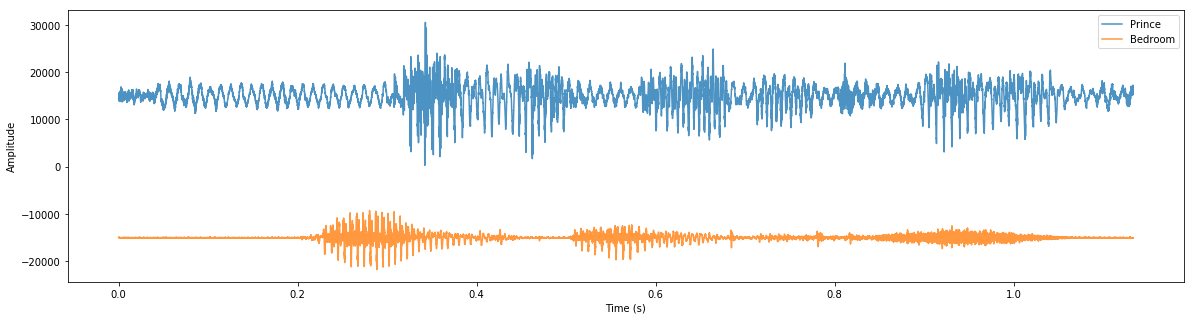

In [0]:
plt.figure(figsize=(20, 5))
plt.plot(np.arange(50000)/fs, prince[150000:200000]+15000, alpha=0.8, label='Prince')
plt.plot(np.arange(50000)/fs, bedroom[150000:200000]-15000, alpha=0.8, label='Bedroom')
plt.legend()
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.savefig(f'{root}Plot/Raw_Input.png')

In [0]:
prince = scaler.fit_transform(prince.reshape(-1, 1)).flatten()
bedroom = scaler.fit_transform(bedroom.reshape(-1, 1)).flatten()

In [0]:
prince = prince[15*fs:]

In [0]:
bedroom_difference = bedroom.size - 20*60*fs
bedroom = bedroom[bedroom_difference:]
prince_difference = prince.size - 20*60*fs
prince = prince[prince_difference:]

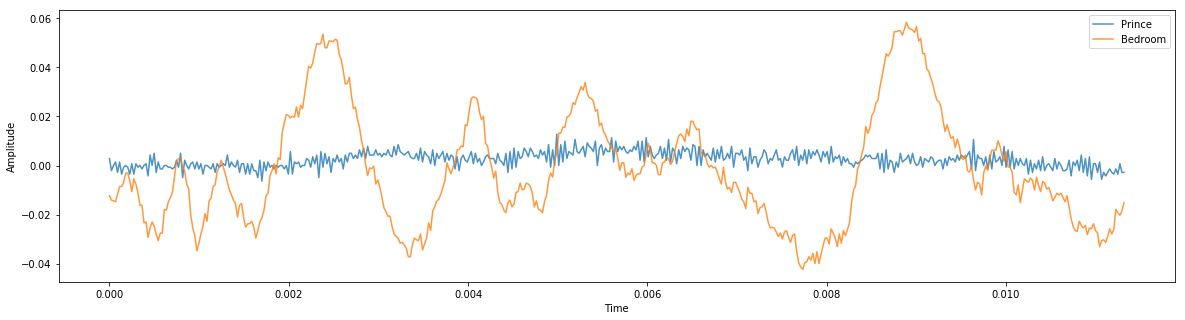

In [0]:
plt.figure(figsize=(20, 5))
plt.plot(np.arange(500)/fs, prince[1500:2000], alpha=0.8, label='Prince')
plt.plot(np.arange(500)/fs, bedroom[1500:2000], alpha=0.8, label='Bedroom')
plt.xlabel('Time')
plt.legend()
plt.ylabel('Amplitude')
plt.savefig(f'{root}Plot/Fitted_Input_Little_portion.png')

In [0]:
def reduce_batch(batch, fs, cut_frequency, i):
  frequenze, tempi, spettro = signal.spectrogram(batch, fs) 
  spettro = spettro[:cut_frequency, :]
  mean_array = np.mean(spettro, 1)
  return mean_array 

In [0]:
def filter_data(batch_seconds, cut_silence, cut_frequency, batch_a, filtered_a, batch_b, filtered_b, freq):
  batch_size = batch_seconds*freq

  # filter out silence regions
  data_a = pd.Series(np.where((filtered_a>cut_silence)==1, batch_a, None))
  data_b = pd.Series(np.where((filtered_b>cut_silence)==1, batch_b, None))
  

  data_a = data_a.dropna(axis=0)
  data_b = data_b.dropna(axis=0)
  
  data_a = data_a.as_matrix()
  data_b = data_b.as_matrix()

  
  data_a = np.asarray(data_a, dtype=np.int16)
  data_b = np.asarray(data_b, dtype=np.int16)
  
  
  # matching X size to be a multiple of the batch size
  data_a = data_a[:-(data_a.size%batch_size)]
  data_b = data_b[:-(data_b.size%batch_size)]
  
  size_batch_a = int(len(data_a) / batch_size)
  size_batch_b = int(len(data_b) / batch_size)
  
  data_a = data_a.reshape(-1, batch_size, order='C')
  data_b = data_b.reshape(-1, batch_size, order='C')
  
  X_a = np.zeros([size_batch_a, cut_frequency])
  for i in range(size_batch_a):
    X_a[i, :] = reduce_batch(data_a[i, :], freq, cut_frequency, i)
  
  X_b = np.zeros([size_batch_b, cut_frequency])
  for i in range(size_batch_b):
    X_b[i, :] = reduce_batch(data_b[i, :], freq, cut_frequency, i)
  
  
  data_a, data_b = None, None
  
  X = np.concatenate([scaler.fit_transform(X_a), scaler.fit_transform(X_b)])
  y_a = np.zeros(size_batch_a)
  y_b = np.ones(size_batch_b)
  y = np.concatenate([y_a, y_b])
  
  X_a, X_b, y_a, y_b = None, None, None, None
  
  return X, y

In [0]:
%%time
filtered_prince = gaussian_filter(np.abs(prince - np.mean(prince)), 100)
filtered_bedroom = gaussian_filter(np.abs(bedroom - np.mean(bedroom)), 100)

CPU times: user 1min 4s, sys: 50 ms, total: 1min 4s
Wall time: 1min 4s


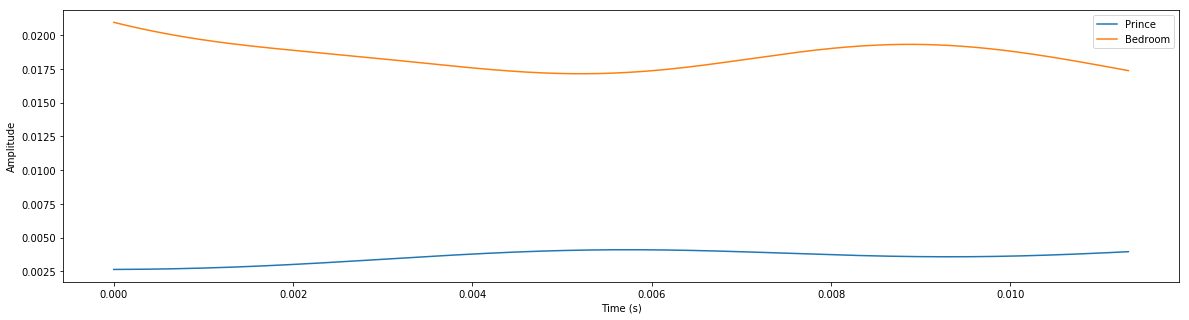

In [0]:
plt.figure(figsize=(20, 5))
plt.plot(np.arange(500)/fs, filtered_prince[1500:2000], label='Prince')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.plot(np.arange(500)/fs, filtered_bedroom[1500:2000], label='Bedroom')
plt.legend()
plt.savefig(f'{root}Plot/Gaussian_Filtered.png')


In [0]:
  freq = fs
  batch_size = batch_seconds*freq

  # filter out silence regions
  mask_a = (filtered_prince>cut_silence)
  mask_b = (filtered_bedroom>cut_silence)
  
  

In [0]:
  data_a = np.where(mask_a==1, prince, None)
  data_b = np.where(mask_b==1, bedroom, None)
  
  data_a = pd.Series(data_a)
  data_b = pd.Series(data_b)
  

  data_a = data_a.dropna(axis=0)
  data_b = data_b.dropna(axis=0)
  
  data_a = data_a.as_matrix()
  data_b = data_b.as_matrix()

  
  data_a = np.asarray(data_a, dtype=np.int16)
  data_b = np.asarray(data_b, dtype=np.int16)
  
  
  # matching X size to be a multiple of the batch size
  data_a = data_a[:-(data_a.size%batch_size)]
  data_b = data_b[:-(data_b.size%batch_size)]
  
  size_batch_a = int(len(data_a) / batch_size)
  size_batch_b = int(len(data_b) / batch_size)
  
  data_a = data_a.reshape(-1, batch_size, order='C')
  data_b = data_b.reshape(-1, batch_size, order='C')

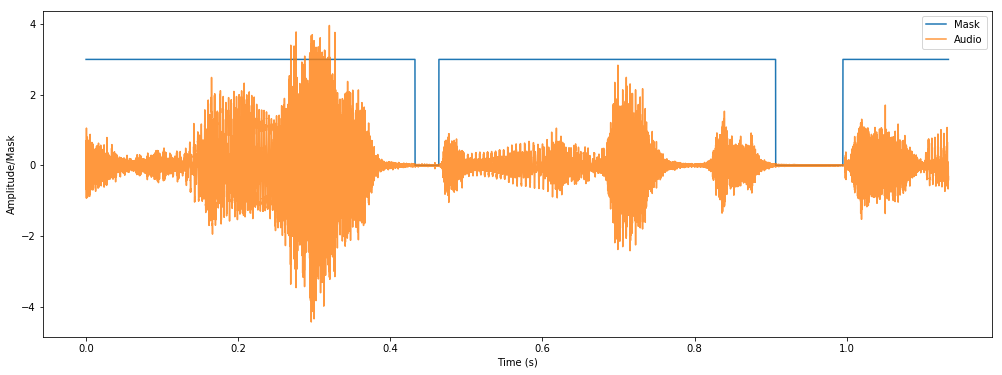

In [168]:
plt.figure(figsize=(17, 6))
plt.plot(np.arange(50000)/fs, mask_b[50000:100000]*3, label='Mask')
plt.plot(np.arange(50000)/fs, bedroom[50000: 100000]/2, alpha=.8, label='Audio')
plt.xlabel('Time (s)')
plt.legend()
plt.ylabel('Amplitude/Mask')
plt.savefig(f'{root}Plot/mask_audio.png')

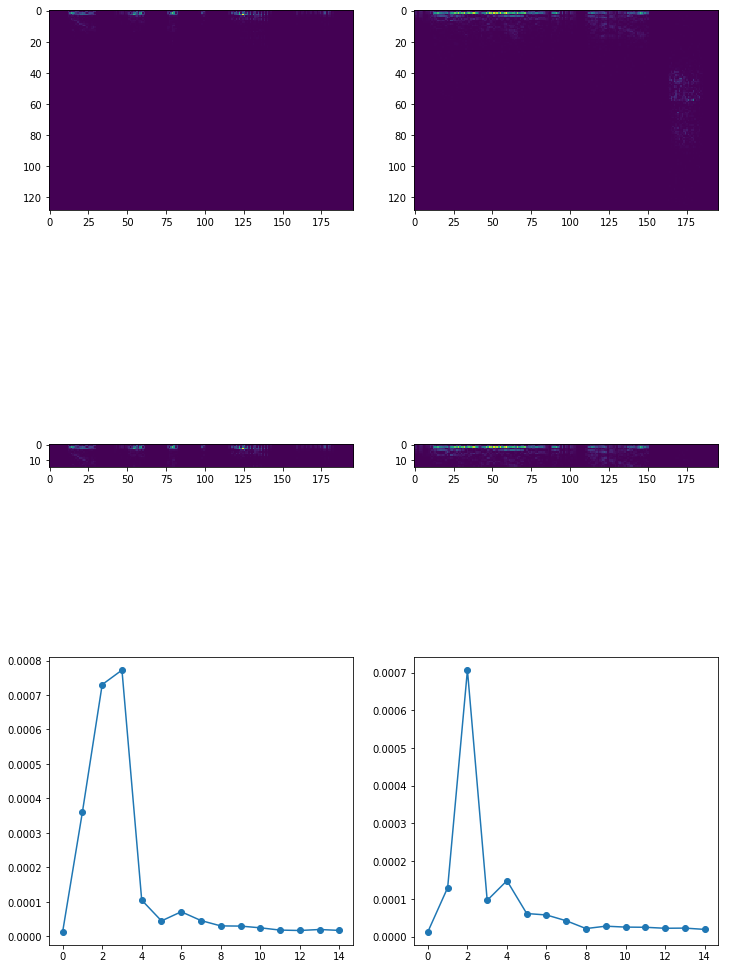

In [0]:
  fig, axs = plt.subplots(3, 2, figsize=(12, 18))
  
  X_a = np.zeros([size_batch_a, cut_frequency])
  for i in range(size_batch_a):
    frequenze, tempi, spettro = signal.spectrogram(data_a[i, :], fs)
    if i == 15:
      axs[0][0].imshow(spettro)
    spettro = spettro[:cut_frequency, :]
    mean_array = np.mean(spettro, 1)
    X_a[i, :] = mean_array
    if i == 15:
      axs[1][0].imshow(spettro)
      axs[2][0].plot(np.arange(cut_frequency), mean_array, 'o-')
  
  X_b = np.zeros([size_batch_b, cut_frequency])
  for i in range(size_batch_b):
    frequenze, tempi, spettro = signal.spectrogram(data_b[i, :], fs)
    if i == 15:
      axs[0][1].imshow(spettro)
    spettro = spettro[:cut_frequency, :]
    mean_array = np.mean(spettro, 1)
    X_b[i, :] = mean_array
    if i == 15:
      axs[1][1].imshow(spettro)
      axs[2][1].plot(np.arange(cut_frequency), mean_array, 'o-', label='Bedroom')
  
  plt.savefig(f'{root}Plot/All_Spectrogram.png')
  
  
  data_a, data_b = None, None

Text(0.5, 0, 'bla')

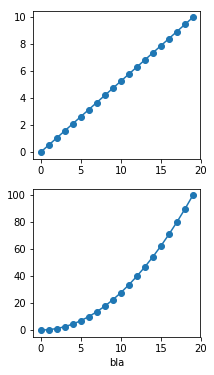

In [0]:
dato1 = np. linspace(0,10, 20)
dato2 = dato1**2


fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(3,6))
ax1.plot(dato1, 'o-')
ax2.plot(dato2, 'o-')

ax2.set_xlabel('bla')

#fig.savaefig('./bal.png')


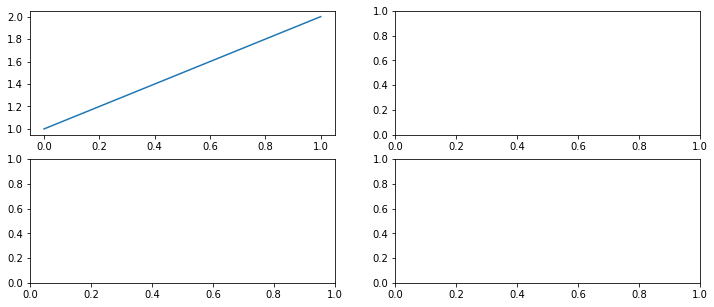

In [0]:
fig, axs = plt.subplots(2, 2, figsize=(12,5))
axs[0][0].plot([1,2])


In [0]:
X = np.concatenate([scaler.fit_transform(X_a), scaler.fit_transform(X_b)])
y_a = np.zeros(size_batch_a)
y_b = np.ones(size_batch_b)
y = np.concatenate([y_a, y_b])
  
X_a, X_b, y_a, y_b = None, None, None, None

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  if sys.path[0] == '':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  del sys.path[0]


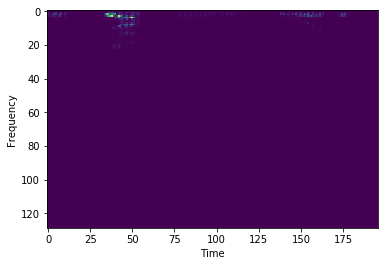

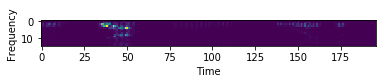

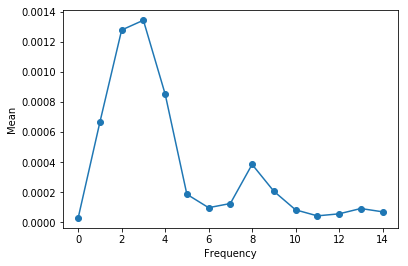

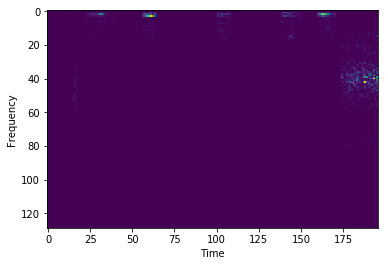

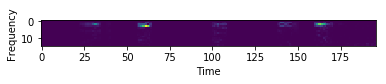

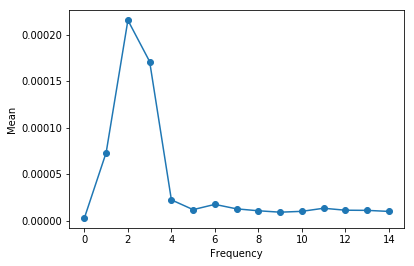

<Figure size 432x288 with 0 Axes>

In [0]:
#_ = filter_data(batch_seconds, cut_silence, 15, prince, filtered_prince, bedroom, filtered_bedroom, fs

In [0]:
4X, y = filter_data(batch_seconds, cut_silence, cut_frequency, prince, filtered_prince, bedroom, filtered_bedroom, fs)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  from ipykernel import kernelapp as app


In [0]:
def progress_bar(current_value, max_value):
    progress = ((current_value+1)/max_value)*100
    if progress>98: progress=100
    print('\r[{0}{1}] {2:.1f}%'.format('#'*int(progress/2), ' '*(50-int(progress/2)), progress), end='')

In [0]:
def graph(batch_p, batch_b):
  quality = 10
  score_train = []
  score_test = []
  dimension = []
  scores=[]
  for i in range(90):
    batch_prince_temp = batch_p[0:i*quality+quality, :]
    batch_bedroom_temp = batch_b[0:i*quality+quality, :]
    batch_prince_temp = scaler.fit_transform(batch_prince_temp)
    batch_bedroom_temp = scaler.fit_transform(batch_bedroom_temp)
    X = np.concatenate([batch_prince_temp, batch_bedroom_temp])
    dimension.append(X.shape[0])
    y_prince = np.zeros(i*quality+quality)
    y_bedroom = np.ones(i*quality+quality)
    y = np.concatenate([y_prince, y_bedroom])
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=40) 
    scores.append(cross_validate(svc, X_train, y_train, cv=5, return_train_score=True))
    #svc.fit(X_train, y_train)
    #score_train.append(svc.score(X_train, y_train))
    #score_test.append(svc.score(X_test, y_test))
  #plt.plot(dimension, score_train, color='red')
  #plt.plot(dimension, score_test, color='blue')
  return scores

In [0]:
def train_CG(batch_prince, batch_bedroom, points):
  values_C = np.logspace(4, 8, points)
  values_G = np.logspace(-5, 1, points)
  scores = [ [] for x in range(points)]
  
  for ic, c in enumerate(values_C):
    for ig, g in enumerate(values_G):    
      svc_temp = SVC(C=c, gamma=g)
      scores[ig].append(cross_validate(svc_temp, batch_prince, batch_bedroom, cv=5, return_train_score=True))
      progress_bar(ic*len(values_G)+ig, len(values_C)*len(values_G))
  return scores, values_C, values_G

In [0]:
def train_SF(batch_prince, batch_prince_filtered, batch_bedroom, batch_bedroom_filtered, points):

  values_S = np.linspace(0.225, 0.5, points)
  values_F = np.linspace(3, 6, points)
  scores = [ [] for x in range(points)]
  
  for iS, s in enumerate(values_S):
    for iF, f in enumerate(values_F):
  #if(True):
    #if(True):
  #    s = 0.1
   #   f = 20
    #  iS = 0
      X_temp, y_temp = filter_data(batch_seconds, s, int(f), batch_prince, batch_prince_filtered, batch_bedroom, batch_bedroom_filtered, fs)
      scores[iS].append(cross_validate(svc, X_temp, y_temp, cv=5, return_train_score=True))
      X_temp, y_temp = None, None
      progress_bar(iS*len(values_F)+iF, len(values_S)*len(values_F))
  return scores, values_S, values_F

In [0]:
scores, values_C, values_G = train_CG(X, y, 2)

[##################################################] 100.0%

In [0]:
scores_SF, values_S, values_F = train_SF(prince, filtered_prince, bedroom, filtered_bedroom, 4)
accuracy_train_mean_SF = np.zeros([len(values_F), len(values_S)])
accuracy_train_std_SF = np.zeros([len(values_F), len(values_S)])
accuracy_test_mean_SF = np.zeros([len(values_F), len(values_S)])
accuracy_test_std_SF = np.zeros([len(values_F), len(values_S)])


for S_coord, F_coord in np.ndindex(len(values_F), len(values_S)):
  accuracy_train_mean_SF[S_coord][F_coord] = np.mean(scores_SF[S_coord][F_coord]['train_score'])
  accuracy_train_std_SF[S_coord][F_coord] = np.std(scores_SF[S_coord][F_coord]['train_score'])
  accuracy_test_mean_SF[S_coord][F_coord] = np.mean(scores_SF[S_coord][F_coord]['test_score'])
  accuracy_test_std_SF[S_coord][F_coord] = np.std(scores_SF[S_coord][F_coord]['test_score'])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  from ipykernel import kernelapp as app


[###                                               ] 6.2%

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  from ipykernel import kernelapp as app


[######                                            ] 12.5%

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  from ipykernel import kernelapp as app


[#########                                         ] 18.8%

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  from ipykernel import kernelapp as app


[############                                      ] 25.0%

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  from ipykernel import kernelapp as app


[###############                                   ] 31.2%

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  from ipykernel import kernelapp as app


[##################                                ] 37.5%

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  from ipykernel import kernelapp as app


[#####################                             ] 43.8%

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  from ipykernel import kernelapp as app


[#########################                         ] 50.0%

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  from ipykernel import kernelapp as app


[############################                      ] 56.2%

In [0]:
plt.contourf(values_S, values_F, accuracy_train_mean_SF)
plt.colorbar()

In [0]:
plt.contourf(values_S, values_F, accuracy_test_mean_SF)
plt.colorbar()

In [0]:
accuracy_train_mean = np.zeros([len(values_C), len(values_G)])
accuracy_train_std = np.zeros([len(values_C), len(values_G)])
accuracy_test_mean = np.zeros([len(values_C), len(values_G)])
accuracy_test_std = np.zeros([len(values_C), len(values_G)])


for c_coord, g_coord in np.ndindex(len(values_C), len(values_G)):
  accuracy_train_mean[g_coord][c_coord] = np.mean(scores[g_coord][c_coord]['train_score'])
  accuracy_train_std[g_coord][c_coord] = np.std(scores[g_coord][c_coord]['train_score'])
  accuracy_test_mean[g_coord][c_coord] = np.mean(scores[g_coord][c_coord]['test_score'])
  accuracy_test_std[g_coord][c_coord] = np.std(scores[g_coord][c_coord]['test_score'])

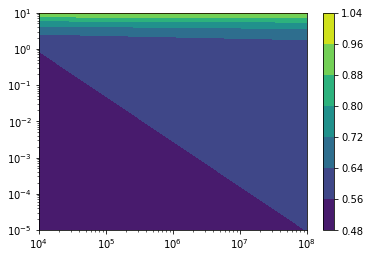

In [0]:
plt.contourf(values_C, values_G, accuracy_train_mean)
plt.colorbar()
plt.xscale('log')
plt.yscale('log')

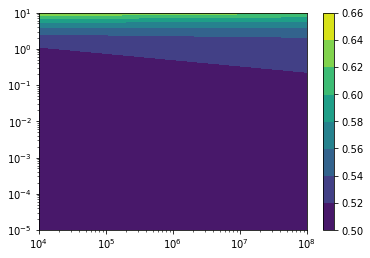

In [0]:
plt.contourf(values_C, values_G, accuracy_test_mean)
plt.colorbar()
plt.xscale('log')
plt.yscale('log')

<ErrorbarContainer object of 3 artists>

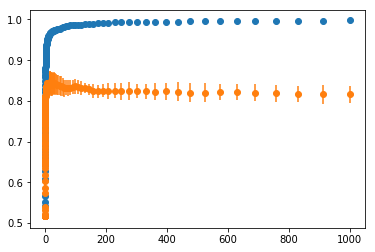

In [0]:
plt.errorbar(values, train_mean, train_std, fmt='o')
plt.errorbar(values, test_mean, test_std, fmt='o')

In [0]:
print(np.max(test_mean), values[np.argmax(test_mean)])

0.8446236559139784 14.149912974345758


In [0]:
scores = graph(batch_prince_final, batch_bedroom_final)
train_mean = np.array([np.mean(x['train_score']) for x in scores])
train_std = np.array([np.std(x['train_score']) for x in scores])
test_mean = np.array([np.mean(x['test_score']) for x in scores])
test_std = np.array([np.std(x['test_score']) for x in scores])

0.8722159657738615 0.8166431816629091


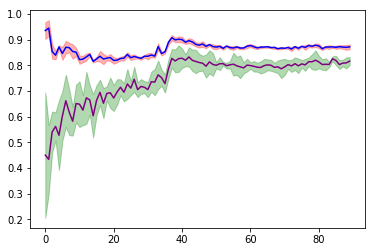

In [0]:
plt.plot(train_mean, c='blue')
plt.fill_between(x=range(90), y1=train_mean-train_std, y2=train_mean+train_std, alpha=0.3, color='red')
plt.plot(test_mean, c='purple')
plt.fill_between(x=range(90), y1=test_mean-test_std, y2=test_mean+test_std, alpha=0.3, color='green')
print(train_mean[len(train_mean)-1], test_mean[len(test_mean)-1])

In [0]:



y_prince = np.zeros(900)
y_bedroom = np.ones(960)
y = np.concatenate([y_prince, y_bedroom])

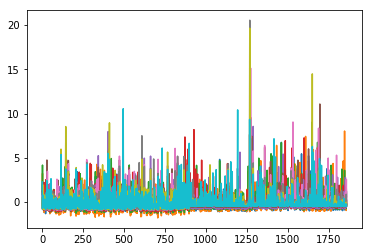

In [0]:
batch_prince_final = scaler.fit_transform(batch_prince_final)
batch_bedroom_final = scaler.fit_transform(batch_bedroom_final)
X = np.concatenate([batch_prince_final, batch_bedroom_final])
plt.plot(X)